# Evaluate model performance with PR curves, confusion matrixes, and F1 scores

## Import libraries

In [1]:
import pathlib
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from joblib import load
from sklearn.metrics import precision_recall_curve

sys.path.append("../utils")
from eval_utils import generate_confusion_matrix_df, generate_f1_score_df, generate_accuracy_score_df
from training_utils import load_data

## Set paths to different datasets and models

In [2]:
# Directory with datasets
data_dir = pathlib.Path("./data")

# Directory with models
models_dir = pathlib.Path("./models")

# Path to encoder file
encoder_path = pathlib.Path("./encoder_results/label_encoder_log_reg_fs_plate_4.joblib")

# Directory for model figures output
fig_dir = pathlib.Path("./figures")
fig_dir.mkdir(exist_ok=True)

# Load in each model individually
final_model = load(
    pathlib.Path(f"{models_dir}/log_reg_fs_plate_4_final_downsample.joblib")
)
shuffled_model = load(
    pathlib.Path(f"{models_dir}/log_reg_fs_plate_4_shuffled_downsample.joblib")
)

## Precision-Recall Curves

### Output PR data per dataset and combine into one df

In [3]:
# Initialize empty lists to store data for each iteration
precision_list = []
recall_list = []
threshold_list = []
model_type_list = []
data_type_list = []

for model_path in models_dir.iterdir():
    print("Evaluating", model_path.stem.split("_")[5], "model...")
    for data_path in data_dir.iterdir():
        print("Applying model to", data_path.stem, "...")
        # load in model to apply to datasets
        model = load(model_path)

        # load in label encoder
        le = load(encoder_path)

        # Load in X and y data from dataset
        X, y = load_data(path_to_data=data_path, label="Metadata_cell_type")

        # Assign y classes to correct binary using label encoder results
        y_binary = le.transform(y)

        # predict class probabilities for morphology feature data
        predicted_probs = model.predict_proba(X)

        # Calculate the precision, recall data
        precision, recall, threshold = precision_recall_curve(
            y_binary, predicted_probs[:, -1]
        )
        threshold = np.append(threshold, np.nan)

        # Append data to lists
        precision_list.extend(precision.tolist())
        recall_list.extend(recall.tolist())
        threshold_list.extend(threshold.tolist())
        model_type_list.extend([model_path.stem.split("_")[5]] * len(precision))
        data_type_list.extend([data_path.stem.split("_")[0]] * len(precision))

# Create a DataFrame from the accumulated data
pr_df = pd.DataFrame(
    {
        "Precision": precision_list,
        "Recall": recall_list,
        "Threshold": threshold_list,
        "Model_Type": model_type_list,
        "Data_Type": data_type_list,
    }
)

# Drop any NA data
pr_df.dropna(inplace=True)

# Show output of all data
print(pr_df.shape)
pr_df.head()

Evaluating shuffled model...
Applying model to testing_data ...
Applying model to holdout2_data ...
Applying model to holdout1_data ...


/home/jenna/CFReT_data/5.machine_learning/../utils/training_utils.py:60: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_to_data, index_col=0)


Applying model to training_data ...
Evaluating final model...
Applying model to testing_data ...
Applying model to holdout2_data ...
Applying model to holdout1_data ...


/home/jenna/CFReT_data/5.machine_learning/../utils/training_utils.py:60: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_to_data, index_col=0)


Applying model to training_data ...
(33720, 5)


,Precision,Recall,Threshold,Model_Type,Data_Type
0,0.374428,1.0,0.048479,shuffled,testing
1,0.374529,1.0,0.068064,shuffled,testing
2,0.374630,1.0,0.096699,shuffled,testing
3,0.374731,1.0,0.097081,shuffled,testing
4,0.374832,1.0,0.106663,shuffled,testing


### Plot precision-recall curves for testing and training data per model type

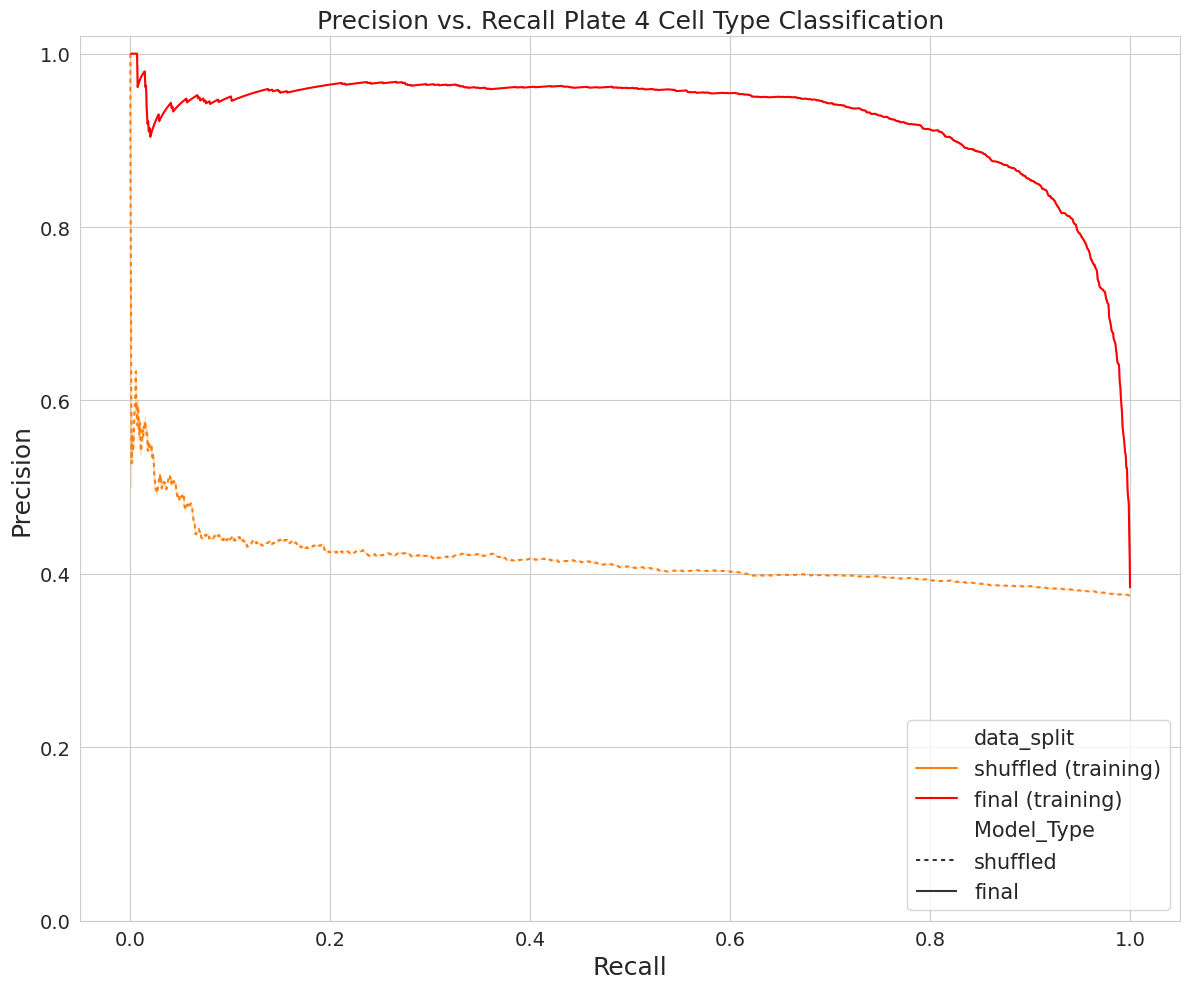

In [4]:
# PR curves with only testing and training data
plt.figure(figsize=(12, 10))
sns.set_style("whitegrid")

# Combine model and data type as one column for plotting
pr_df["data_split"] = pr_df["Model_Type"] + " (" + pr_df["Data_Type"] + ")"

# Filter data frame to only show training versus testing
filtered_df = pr_df[pr_df["Data_Type"].isin(["training"])]

# Define colors for each condition
colors = {"final (training)": "red", "shuffled (training)": "#ff7f0e"}

sns.lineplot(
    x="Recall",
    y="Precision",
    hue="data_split",
    style="Model_Type",
    dashes={"final": (1, 0), "shuffled": (2, 2)},
    palette=colors,
    data=filtered_df,
)

plt.legend(loc="lower right", fontsize=15)
plt.ylim(bottom=0.0, top=1.02)
plt.xlabel("Recall", fontsize=18)
plt.ylabel("Precision", fontsize=18)
plt.title("Precision vs. Recall Plate 4 Cell Type Classification", fontsize=18)

# Adjust x-axis ticks font size
plt.xticks(fontsize=14)

# Adjust y-axis ticks font size and labels
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig(f"{fig_dir}/precision_recall_plate4_downsample_only_training.png", dpi=500)

plt.show()

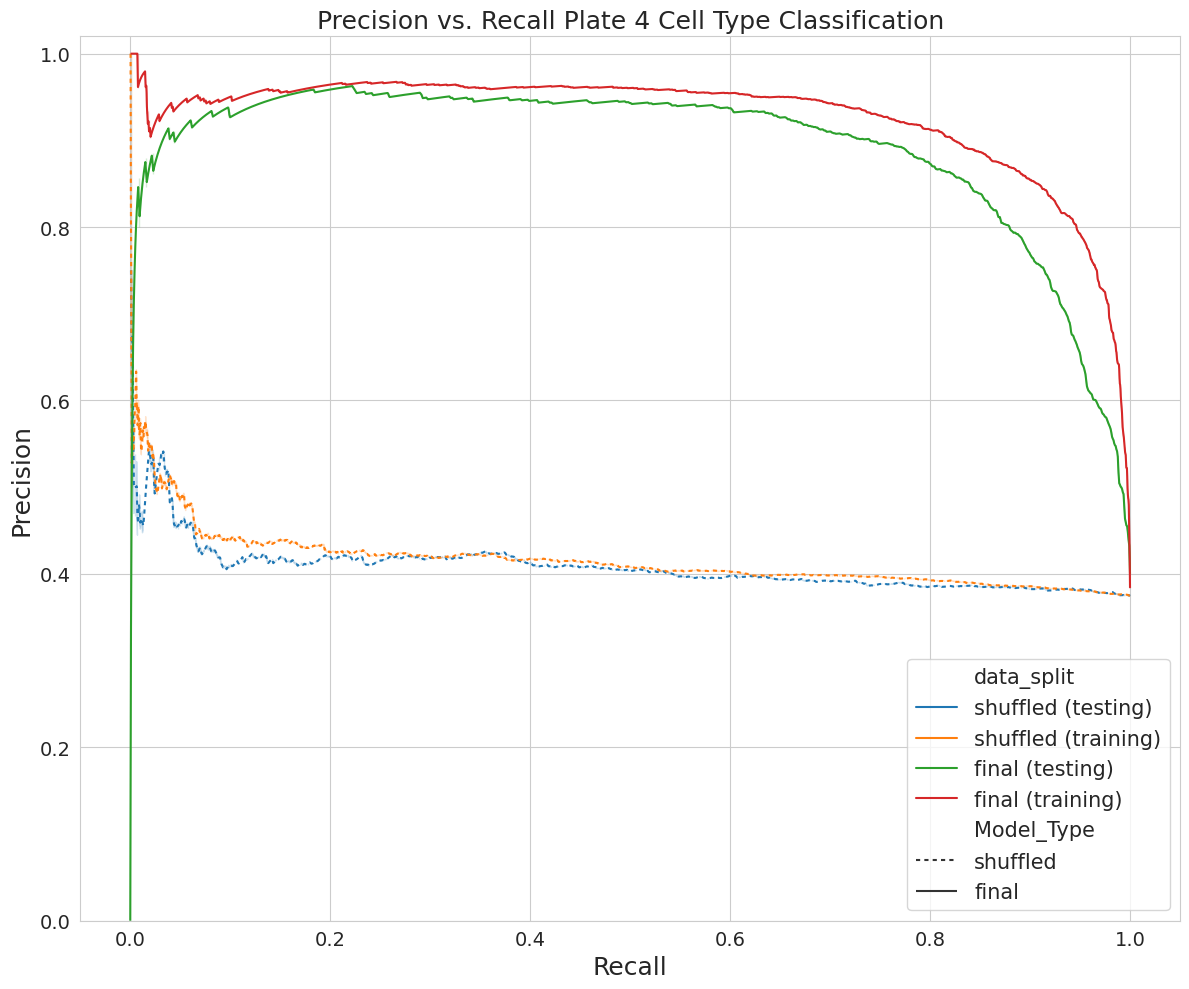

In [5]:
# PR curves with only testing and training data
plt.figure(figsize=(12, 10))
sns.set_style("whitegrid")

# Combine model and data type as one column for plotting
pr_df["data_split"] = pr_df["Model_Type"] + " (" + pr_df["Data_Type"] + ")"

# Filter data frame to only show training versus testing
filtered_df = pr_df[pr_df["Data_Type"].isin(["training", "testing"])]

sns.lineplot(
    x="Recall",
    y="Precision",
    hue="data_split",
    style="Model_Type",
    dashes={"final": (1, 0), "shuffled": (2, 2)},
    data=filtered_df,
)

plt.legend(loc="lower right", fontsize=15)
plt.ylim(bottom=0.0, top=1.02)
plt.xlabel("Recall", fontsize=18)
plt.ylabel("Precision", fontsize=18)
plt.title("Precision vs. Recall Plate 4 Cell Type Classification", fontsize=18)

# Adjust x-axis ticks font size
plt.xticks(fontsize=14)

# Adjust y-axis ticks font size and labels
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig(f"{fig_dir}/precision_recall_plate4_downsample.pdf", dpi=500)

plt.show()

### Plot precision-recall curves for holdout data per model type

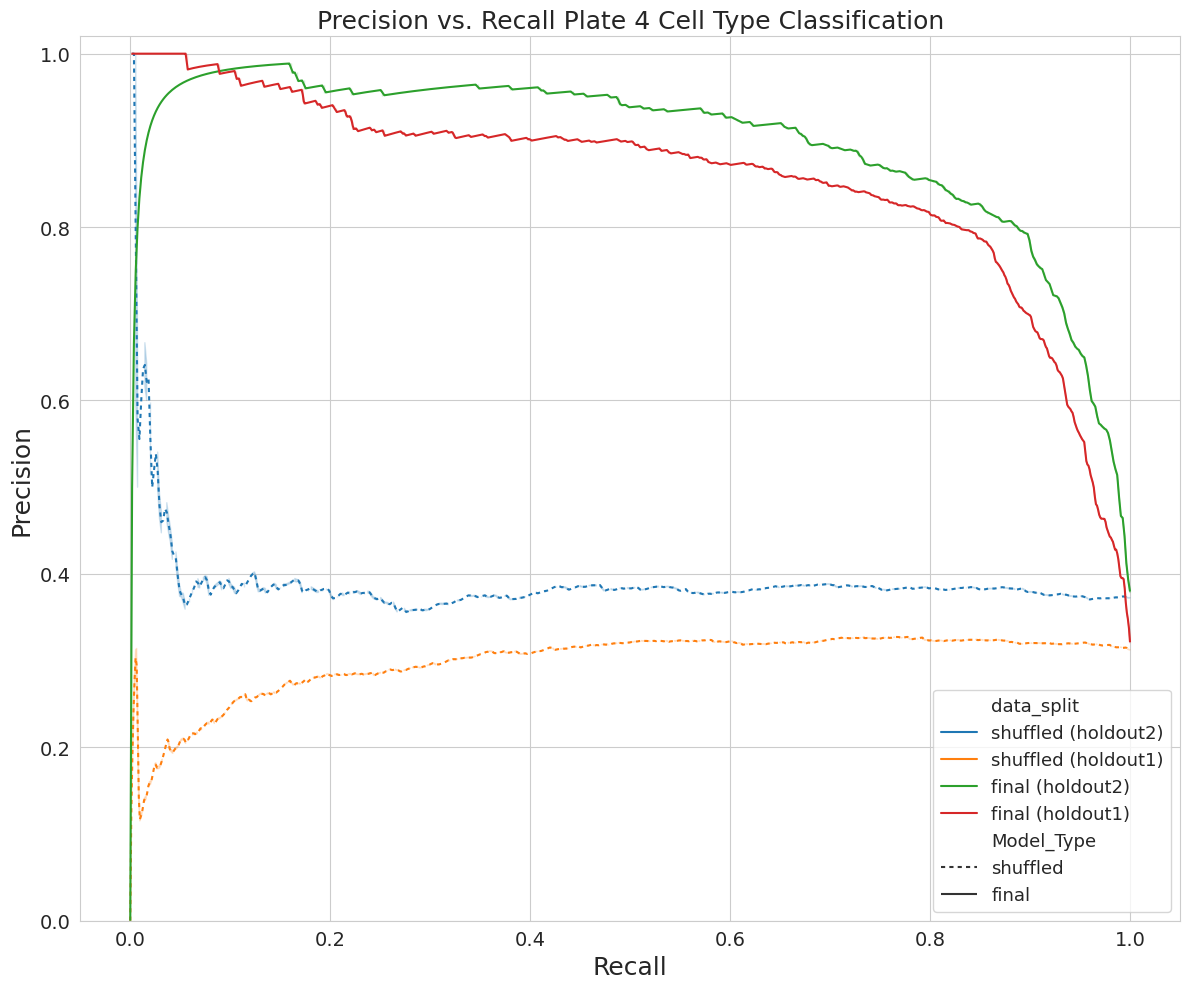

In [6]:
# PR curves with hold-out data
plt.figure(figsize=(12, 10))
sns.set_style("whitegrid")

# Combine model and data type as one column for plotting
pr_df["data_split"] = pr_df["Model_Type"] + " (" + pr_df["Data_Type"] + ")"

# Filter data frame to only show holdout datasets
filtered_df = pr_df[pr_df["Data_Type"].isin(["holdout1", "holdout2"])]

sns.lineplot(
    x="Recall",
    y="Precision",
    hue="data_split",
    style="Model_Type",
    dashes={"final": (1, 0), "shuffled": (2, 2)},
    data=filtered_df,
)

plt.legend(loc="lower right", fontsize=13)
plt.ylim(bottom=0.0, top=1.02)
plt.xlabel("Recall", fontsize=18)
plt.ylabel("Precision", fontsize=18)
plt.title("Precision vs. Recall Plate 4 Cell Type Classification", fontsize=18)

# Adjust x-axis ticks font size
plt.xticks(fontsize=14)

# Adjust y-axis ticks font size and labels
plt.yticks(fontsize=14)

plt.tight_layout()
plt.savefig(f"{fig_dir}/precision_recall_plate4_holdout_data_downsample.png", dpi=500)

plt.show()

## Confusion Matrices

### Generate confusion matrix plots for each data set and model type

In [7]:
# List of paths that contains each model
path_list = list(models_dir.glob("*"))

# List of data sets to apply models to
data_set_list = ["training", "testing", "holdout1", "holdout2"]

# Path to encoder file
encoder_path = pathlib.Path("./encoder_results/label_encoder_log_reg_fs_plate_4.joblib")

# Metadata column used for classifying
label = "Metadata_cell_type"

# Iterate over each model path
for model_path in path_list:
    # Iterate over each dataset
    for data_set in data_set_list:
        print(
            "Generating plot for",
            data_set.capitalize(),
            model_path.stem.split("_")[5].capitalize(),
        )
        # Generate confusion matrix data frame
        df = generate_confusion_matrix_df(
            model_path=model_path,
            data_dir=data_dir,
            encoder_path=encoder_path,
            label=label,
            data_set=data_set,
        )

        # Rename binary labels to failing versus healthy
        df["True_Label"] = df["True_Label"].replace({0: "Failing", 1: "Healthy"})
        df["Predicted_Label"] = df["Predicted_Label"].replace(
            {0: "Failing", 1: "Healthy"}
        )

        # Plot confusion matrix
        plt.figure(figsize=(12, 10))
        sns.set_style("whitegrid")

        sns.heatmap(
            data=df.pivot(
                index="True_Label", columns="Predicted_Label", values="Recall"
            ),
            annot=df.pivot(
                index="True_Label", columns="Predicted_Label", values="Count"
            ),
            fmt=".0f",
            cmap="Reds",
            square=True,
            vmin=0,  # Set vmin here
            vmax=1,  # Set vmax here
            cbar_kws={"label": "Recall"},
            xticklabels=["Failing", "Healthy"],
            yticklabels=["Failing", "Healthy"],
            linewidths=0.5,
            annot_kws={"size": 14},
            mask=(
                df.pivot(
                    index="True_Label", columns="Predicted_Label", values="Count"
                ).isna()
            ),
        )

        plt.title(
            f"Confusion Matrix for {data_set.capitalize()} Data - Model: {model_path.stem.split('_')[5].capitalize()}"
        )
        plt.tight_layout()
        plt.savefig(
            f"{fig_dir}/plate4_confusion_matrix_{data_set}_{model_path.stem.split('_')[5]}_downsample.png",
            dpi=500,
        )
        plt.close()

Generating plot for Training Shuffled
Generating plot for Testing Shuffled
Generating plot for Holdout1 Shuffled


/home/jenna/CFReT_data/5.machine_learning/../utils/training_utils.py:60: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_to_data, index_col=0)


Generating plot for Holdout2 Shuffled
Generating plot for Training Final
Generating plot for Testing Final
Generating plot for Holdout1 Final


/home/jenna/CFReT_data/5.machine_learning/../utils/training_utils.py:60: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_to_data, index_col=0)


Generating plot for Holdout2 Final


## F1 scores

### Concat F1 scores from all datasets and model types

In [8]:
# List of paths that contains each model
path_list = list(models_dir.glob("*"))

# Metadata column used for classifying
label = "Metadata_cell_type"

dfs = []

# Iterate over each model path
for model_path in path_list:
    # Iterate over each dataset
    for data_set in data_set_list:
        print(data_set.capitalize(), model_path.stem.split("_")[5].capitalize())
        # Generate confusion matrix data frame
        df = generate_f1_score_df(
            model_path=model_path,
            data_dir=data_dir,
            encoder_path=encoder_path,
            label=label,
            data_set=data_set,
        )

        # Rename binary labels to failing versus healthy
        df = df.rename(columns={0: "Failing", 1: "Healthy"})

        # Add columns for model and data_set
        df["Model"] = model_path.stem.split("_")[5].capitalize()
        df["Data_Set"] = data_set.capitalize()

        # Append the DataFrame to the list
        dfs.append(df)

concat_f1_scores = pd.concat(dfs, ignore_index=True)

Training Shuffled
Testing Shuffled
Holdout1 Shuffled


/home/jenna/CFReT_data/5.machine_learning/../utils/training_utils.py:60: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_to_data, index_col=0)


Holdout2 Shuffled
Training Final
Testing Final
Holdout1 Final
Holdout2 Final


/home/jenna/CFReT_data/5.machine_learning/../utils/training_utils.py:60: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path_to_data, index_col=0)


### Check if output looks correct

In [9]:
print(concat_f1_scores.shape)
concat_f1_scores.head()

(8, 5)


,Failing,Healthy,Weighted,Model,Data_Set
0,0.606624,0.448968,0.547585,Shuffled,Training
1,0.591913,0.453401,0.540050,Shuffled,Testing
2,0.564753,0.408003,0.515821,Shuffled,Holdout1
3,0.560782,0.447348,0.518543,Shuffled,Holdout2
4,0.921621,0.877732,0.905185,Final,Training


### Plot F1 scores for only testing and training data

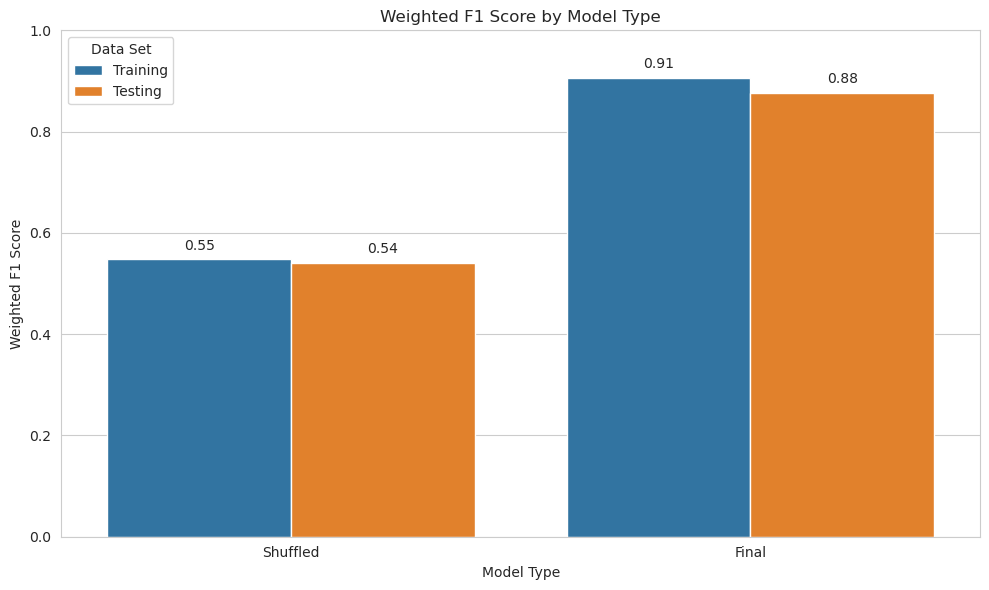

In [10]:
plt.figure(figsize=(10, 6))

# Set y-axis limits
plt.ylim(0, 1)

# Filter the data to include only training and testing sets
filtered_data = concat_f1_scores[
    concat_f1_scores["Data_Set"].isin(["Training", "Testing"])
]

ax = sns.barplot(x="Model", y="Weighted", hue="Data_Set", data=filtered_data)

# Add the weighted values above the bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(
            f"{height:.2f}",
            (p.get_x() + p.get_width() / 2.0, height),
            ha="center",
            va="center",
            xytext=(0, 10),
            textcoords="offset points",
        )

plt.title("Weighted F1 Score by Model Type")
plt.xlabel("Model Type")
plt.ylabel("Weighted F1 Score")
plt.legend(title="Data Set")
plt.tight_layout()

plt.savefig(f"{fig_dir}/f1_scores_plate4_downsample.png", dpi=500)

plt.show()

### Plot F1 scores for holdout data

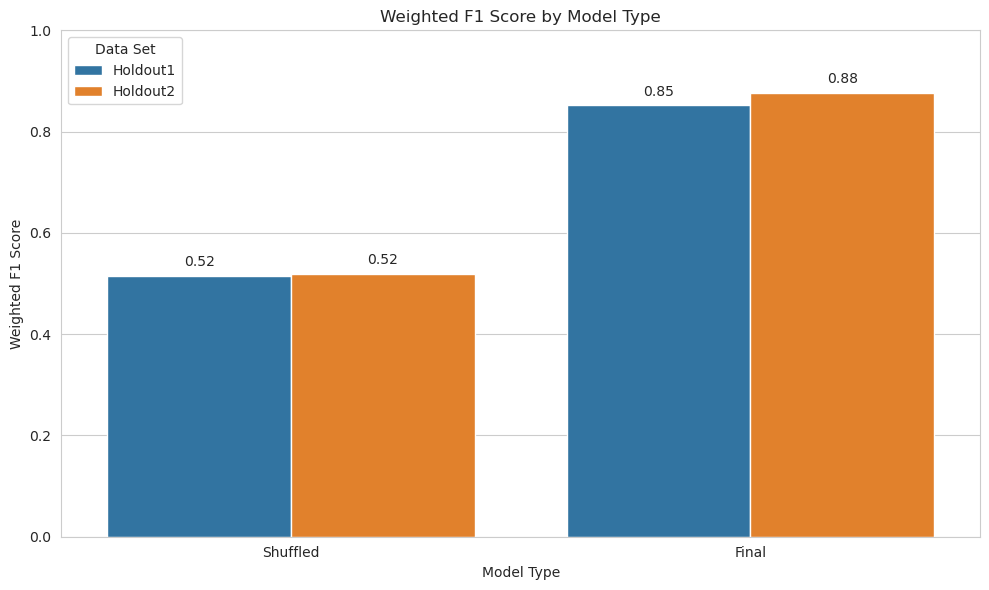

In [11]:
plt.figure(figsize=(10, 6))

# Set y-axis limits
plt.ylim(0, 1)

# Filter the data to include only hold-out sets
filtered_data = concat_f1_scores[
    concat_f1_scores["Data_Set"].isin(["Holdout1", "Holdout2"])
]

ax = sns.barplot(x="Model", y="Weighted", hue="Data_Set", data=filtered_data)

# Add the weighted values above the bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(
            f"{height:.2f}",
            (p.get_x() + p.get_width() / 2.0, height),
            ha="center",
            va="center",
            xytext=(0, 10),
            textcoords="offset points",
        )

plt.title("Weighted F1 Score by Model Type")
plt.xlabel("Model Type")
plt.ylabel("Weighted F1 Score")
plt.legend(title="Data Set")
plt.tight_layout()

plt.savefig(f"{fig_dir}/f1_scores_plate4_holdout_data_downsample.png", dpi=500)

plt.show()

## Generate accuracy scores specifically from the whole plate 4 dataset per heart

In [12]:
# List of paths that contains each model
path_list = list(models_dir.glob("*"))

# Metadata column used for classifying
label = "Metadata_cell_type"

dfs = []

# Iterate over each model path
for model_path in path_list:
    # Iterate over each dataset
    for data_set in data_set_list:
        print(data_set.capitalize(), model_path.stem.split("_")[5].capitalize())
        
        # Load the dataset
        data_path = data_dir / f"{data_set}_data.csv"
        data_df = pd.read_csv(data_path)
        
        # Group the data by heart number
        grouped_data = data_df.groupby("Metadata_heart_number")
        
        # Iterate over each group (heart number)
        for heart_number, df_heart in grouped_data:
            # Generate accuracy data frame
            df = generate_accuracy_score_df(
                model_path=model_path,
                data_set=df_heart,
                encoder_path=encoder_path,
                label=label
            )

            # Rename binary labels to failing versus healthy
            df = df.rename(columns={0: "Failing", 1: "Healthy"})

            # Add columns for model, data_set, and heart number
            df["Model"] = model_path.stem.split("_")[5].capitalize()
            df["Data_Set"] = data_set.capitalize()
            df["Heart_Number"] = heart_number

            # Append the DataFrame to the list
            dfs.append(df)

concat_accuracy_scores = pd.concat(dfs, ignore_index=True)

concat_accuracy_scores.to_csv("./accuracy_scores_per_heart.csv", index=False)


Training Shuffled
Testing Shuffled
Holdout1 Shuffled


/tmp/ipykernel_766748/2028180701.py:17: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data_df = pd.read_csv(data_path)


Holdout2 Shuffled
Training Final
Testing Final
Holdout1 Final


/tmp/ipykernel_766748/2028180701.py:17: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  data_df = pd.read_csv(data_path)


Holdout2 Final


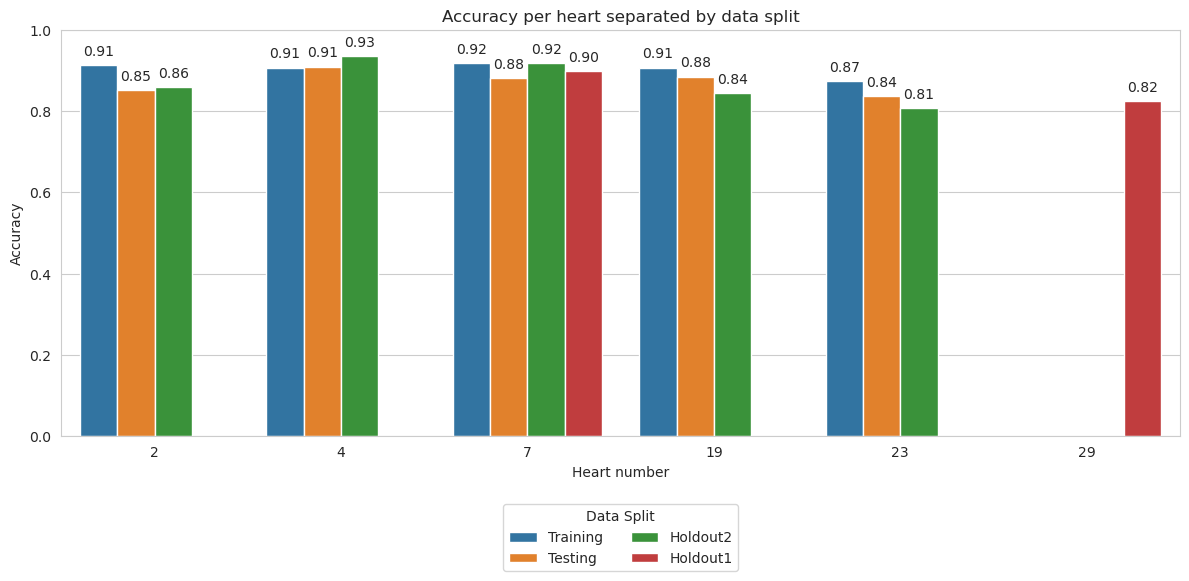

In [13]:
plt.figure(figsize=(12, 6))  # Adjust the width of the figure

# Set y-axis limits
plt.ylim(0, 1)

filtered_accuracy_df = concat_accuracy_scores[concat_accuracy_scores['Model'] != 'Shuffled']

ax = sns.barplot(x="Heart_Number", y="Accuracy", hue="Data_Set", data=filtered_accuracy_df)

# Add the weighted values above the bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(
            f"{height:.2f}",
            (p.get_x() + p.get_width() / 2.0, height),
            ha="center",
            va="center",
            xytext=(0, 10),
            textcoords="offset points",
        )

plt.title("Accuracy per heart separated by data split")
plt.xlabel("Heart number")
plt.ylabel("Accuracy")
plt.legend(title="Data Split", bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)  # Move legend to the middle
plt.tight_layout()

plt.show()


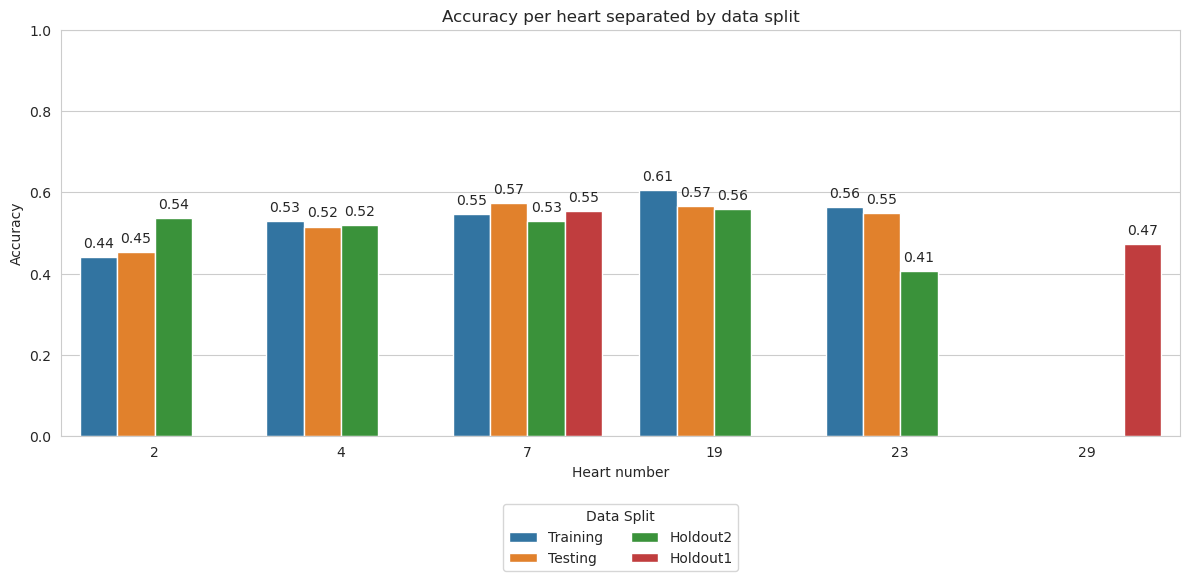

In [14]:
plt.figure(figsize=(12, 6))  # Adjust the width of the figure

# Set y-axis limits
plt.ylim(0, 1)

filtered_accuracy_df = concat_accuracy_scores[concat_accuracy_scores['Model'] != 'Final']

ax = sns.barplot(x="Heart_Number", y="Accuracy", hue="Data_Set", data=filtered_accuracy_df)

# Add the weighted values above the bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(
            f"{height:.2f}",
            (p.get_x() + p.get_width() / 2.0, height),
            ha="center",
            va="center",
            xytext=(0, 10),
            textcoords="offset points",
        )

plt.title("Accuracy per heart separated by data split")
plt.xlabel("Heart number")
plt.ylabel("Accuracy")
plt.legend(title="Data Split", bbox_to_anchor=(0.5, -0.15), loc='upper center', ncol=2)  # Move legend to the middle
plt.tight_layout()

plt.show()
